<center> <b> <font size="3"> <font color="green">rfborg </font> :
    your detector technology will be assimilated— resistance is futile! </font> </b> </center> 

In [1]:
import os
from pynq import Overlay
from pynq import Xlnk
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import signal

In [2]:
# FIRMWARE UPLOAD
firmware = Overlay('bram_lutwave2p1.bit')
# INITIALIZING LMK04208 CLOCK
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

In [233]:
# Generating DAC Waveform
addr_size=11
channels= 16
data_p = channels*2**(addr_size) # 21 # length of timestream or length of LUT+1
fs = 4096.0e6 # sampling rate of D/A, FPGA fabric = fs/2
C=1 # decimation factor
# #####################################################
# # SET FREQ
# #####################################################
N=5
#freqs = np.linspace(500e6,900e6,N)*C
psi=np.arange(-np.pi,np.pi,.0001)
freqs = np.arange(500e6,1510e6,500e6)*C
print(freqs/1e6)
A = 2**15-1 # 16 bit D/A, expecting signed values.
freq_res = fs/data_p # Hz
# #####################################################
# # IQ balancing
# s1 = 1.0
# s2 = 1.0
pi = np.pi

################################
# GENERATE WAVEFORM FROM FREQ
################################
freqs = np.round(freqs/(freq_res))*freq_res
delta = np.zeros(data_p,dtype="complex") # empty array of deltas
for i in range(len(freqs)):
    bin_num = np.round((freqs[i]/freq_res)).astype('int')
    delta[bin_num] = (1+1j)*np.exp(1j*np.random.choice(psi))
ts = np.fft.ifft(delta, norm="ortho")
I = ((ts.real/max(ts.real))*A).astype("int16")
Q = ((ts.imag/max(ts.imag)*A)).astype("int16")

I2 = []
Q2 = []
Q_val = ((np.int32(Q[1::2]) << 16) + Q[0::2]).astype("int32")
I_val = ((np.int32(I[1::2]) << 16) + I[0::2]).astype("int32")

# plt.figure()
# plt.plot(I[0:100],label="I")
# plt.plot(Q[0:100],label="Q")
# plt.legend()
# plt.show()

[  500.  1000.  1500.]


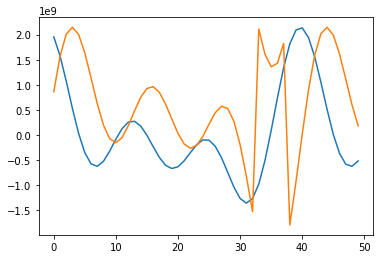

In [221]:
plt.plot(I_val[0:50])
plt.plot(Q_val[0:50])

In [4]:
ADC_bram_I = firmware.DAC_I.BRAM_I_LUT
ADC_bram_Q = firmware.DAC_Q.BRAM_Q_LUT

#BRAM driver code for bram v0.42

veclen=2**8
vecoffs=2**19

def load_lut2(bramN,Z): # new stacked python functionality with new config
    wea=2**29
    memlen=2**11
    load=2**29
    sclr=2**31
    
    bramN.write(4,wea)
    k=int(0)
    for i in range(0,memlen):
        #bram.write(4,1<<28)
        bramN.write(0, k<<(32-11))
        bramN.write(4,wea)
        #print("i: " + str(i))
        for j in range(8):
            #print(f"{i}: {i<<16}") 
            bramN.write(4,j<<19)
            bramN.write(12,int(Z[8*i+j])) 
            #print(str(8*i+j) + "\t" + hex(Z[8*i+j]))
        
        bramN.write(4,wea | 1<<28 )
            #bram.write(4,load)
        k+=1
        
    bramN.write(4,0)     
    bramN.write(0, 0)

"""
def clear_lut(bram):
    load=2**29
    memlen=(2**11)#-2**8
    bram.write(4,load)
    for i in range(memlen):
        bram.write(0,i<<(32-11)) #write addr
        bram.write(12,0) #write array index to port
    bram.write(4,0)
    
def load_lut(bram,Z):
    inB = 2**29 # | 2**30
    memlen = 2**11
    for i in range(memlen):
        bram.write(4,0)
        bram.write(0,i<<(32-11)) #write addr
        print(Z[i])
        bram.write(12,int(Z[i])) #write array index to port
            
        bram.write(4,inB)
        bram.write(4,0)
"""

'\ndef clear_lut(bram):\n    load=2**29\n    memlen=(2**11)#-2**8\n    bram.write(4,load)\n    for i in range(memlen):\n        bram.write(0,i<<(32-11)) #write addr\n        bram.write(12,0) #write array index to port\n    bram.write(4,0)\n    \ndef load_lut(bram,Z):\n    inB = 2**29 # | 2**30\n    memlen = 2**11\n    for i in range(memlen):\n        bram.write(4,0)\n        bram.write(0,i<<(32-11)) #write addr\n        print(Z[i])\n        bram.write(12,int(Z[i])) #write array index to port\n            \n        bram.write(4,inB)\n        bram.write(4,0)\n'

In [236]:
load_lut2(ADC_bram_I,I_val)
load_lut2(ADC_bram_Q,Q_val)

In [121]:
bram_DAC_I = firmware.ADC_I.BRAM_SNAP_0 
bram_DAC_Q = firmware.ADC_Q.BRAM_SNAP_0

def get_snap_data(snap):
  snap.write(0x04,0)       #
  snap.write(0x04,2**31)   # toggling sync clear
  snap.write(0x04,2**29)       # 
  d = np.zeros(8*2**11)# bram data
  for i in range(2**11):
    snap.write(0x00,i<<(32-11)) # write address space to read
    for j in range(8):
      snap.write(0x04,j<<19)
      data = snap.read(0x08)
      d[i*8+j]= data
      #print(str(i*8+j))
  snap_data = np.array(d).astype("int32")
  snap_data_0 = ((snap_data >> 16).astype("int16"))#.astype('float') # decoding concatenated values
  snap_data_1 = ((snap_data & 2**(16)-1).astype("int16"))#.astype('float') 
  d2 = np.zeros(2*8*2**11)# bram data
  d2[0::2]=snap_data_1
  d2[1::2]=snap_data_0
  return d2

In [234]:
Q3=get_snap_data(bram_DAC_Q)
I3=get_snap_data(bram_DAC_I)

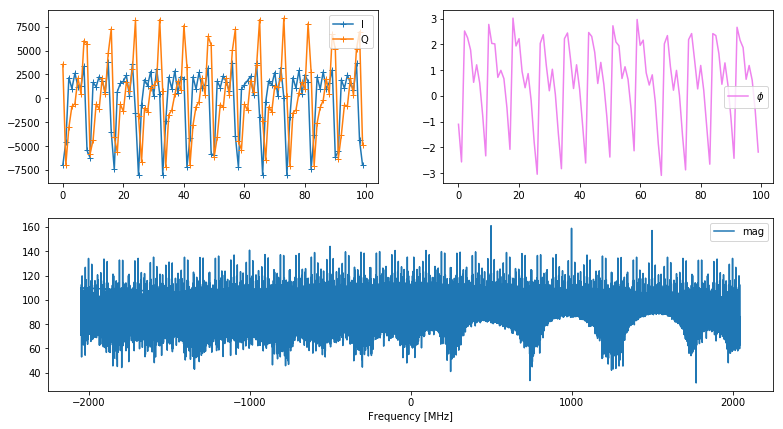

In [246]:
Q3=get_snap_data(bram_DAC_Q) # Q must run first, I is dependent on Q triggering!!!
I3=get_snap_data(bram_DAC_I)
plt.figure(figsize=(13,7))
c = slice(0,100)
plt.subplot(221)
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
plt.legend()
plt.subplot(222)
plt.plot(np.arctan2(I3[c],Q3[c]),color="violet",label=r'$\phi$')
plt.legend()
plt.subplot(2,2,(3,4))
spec=np.fft.fft(I3+1j*Q3)
spec_freqs = np.fft.fftfreq(len(I3),1./4096.e6)
spec=abs(spec)
#plt.plot(spec_freqs/1e6,np.real(spec*np.conj(spec)),label="mag")
plt.plot(spec_freqs/1e6,20*np.log10(spec),label="mag")
plt.xlabel("Frequency [MHz]")
plt.legend()
plt.show()

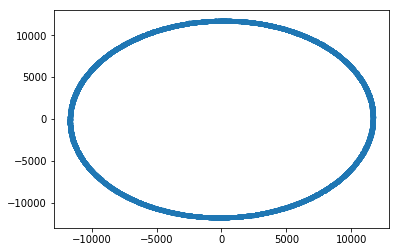

In [138]:
plt.plot(I3,Q3,'.')

In [213]:
np.fft.fftfreq?

In [242]:
abs(1/np.sqrt(2)+1j*1/np.sqrt(2))

0.99999999999999989